# This notebook test the BERT fine tuning model
https://www.kaggle.com/code/studystuffme/belka-bert-finetuning/notebook

In [1]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
from datasets import*
from rdkit import Chem
from rdkit.Chem import AllChem
import seaborn as sns 

/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/raw_data/train_split.parquet'
test_path = '/mnt/isilon/wang_lab/pengwang/projects/Belka/raw_data/train_split.parquet'

con = duckdb.connect()

small_df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 30000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 30000)""").df()

con.close()

In [3]:
small_df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,66214972,N#Cc1ccc(C[C@H](CC(=O)O)NC(=O)OCC2c3ccccc3-c3c...,Nc1cc(Br)ccc1CO,COC(=O)c1cc(Cl)nc(Cl)c1N,COC(=O)c1cc(Cl)nc(Cl)c1Nc1nc(Nc2cc(Br)ccc2CO)n...,HSA,0
1,61912980,Cc1ccccc1[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2c...,Nc1ccc(Cn2ccnc2)cc1,CC1(C)CC(CCN)C(=O)N1.Cl,Cc1ccccc1[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2CC(C)(C...,BRD4,0
2,53359771,Cc1cc(Cl)cc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Nc1ncc[nH]c1=O,Cc1cccc2sc(N)nc12,Cc1cc(Cl)cc(C(=O)N[Dy])c1Nc1nc(Nc2nc3c(C)cccc3...,HSA,0
3,38598008,COc1cccc(C(=O)O)c1NC(=O)OCC1c2ccccc2-c2ccccc21,Cl.Cl.NCC1CCN(CC(F)F)CC1,NCc1nc(-c2ccsc2)no1,COc1cccc(C(=O)N[Dy])c1Nc1nc(NCc2nc(-c3ccsc3)no...,sEH,0
4,119466152,O=C(N[C@H](Cc1ccc(-c2ccccc2)cc1)C(=O)O)OCC1c2c...,N#Cc1ncc(N)cc1C(F)(F)F,Nc1nc(-c2ccccc2Cl)cs1,N#Cc1ncc(Nc2nc(Nc3nc(-c4ccccc4Cl)cs3)nc(N[C@H]...,sEH,0


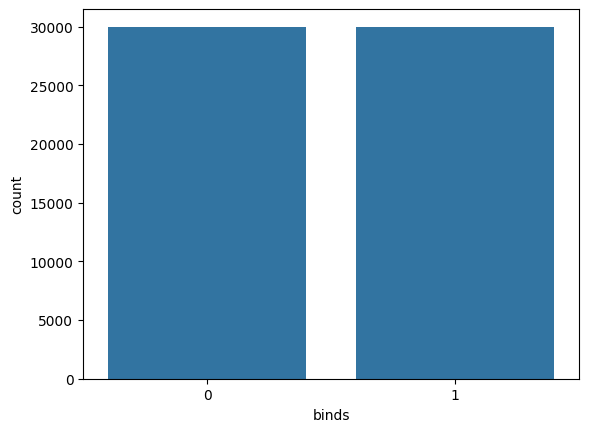

In [4]:
sns.countplot(data=small_df,x='binds');

## feature engineering (generate input texx)

In [5]:
# use [SEP] token to separate two test inputs (SMILE and protein_name)
small_df['text'] = small_df['molecule_smiles']+ '[SEP]' + small_df['protein_name']
#small_df.head(5)

In [6]:
small_df.columns

Index(['id', 'buildingblock1_smiles', 'buildingblock2_smiles',
       'buildingblock3_smiles', 'molecule_smiles', 'protein_name', 'binds',
       'text'],
      dtype='object')

In [7]:
small_df = small_df.drop(['id', 'buildingblock1_smiles', 'buildingblock2_smiles',
       'buildingblock3_smiles', 'molecule_smiles', 'protein_name'],axis=1)
small_df.head()

,binds,text
0,0,COC(=O)c1cc(Cl)nc(Cl)c1Nc1nc(Nc2cc(Br)ccc2CO)n...
1,0,Cc1ccccc1[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2CC(C)(C...
2,0,Cc1cc(Cl)cc(C(=O)N[Dy])c1Nc1nc(Nc2nc3c(C)cccc3...
3,0,COc1cccc(C(=O)N[Dy])c1Nc1nc(NCc2nc(-c3ccsc3)no...
4,0,N#Cc1ncc(Nc2nc(Nc3nc(-c4ccccc4Cl)cs3)nc(N[C@H]...


In [8]:
dataset = Dataset.from_pandas(small_df)
dataset

Dataset({
    features: ['binds', 'text'],
    num_rows: 60000
})

In [9]:
dataset = dataset.rename_column('binds','label')
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 48000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 12000
    })
})

In [10]:
train_df = dataset['train']
test_df = dataset['test']

In [11]:
id2label = {0:'No bind',1:'Bind'}
label2id = {'No bind':0,'Bind':1}

In [12]:
from transformers import BertTokenizer, BertTokenizerFast,BertForSequenceClassification,Trainer,TrainingArguments

2024-06-13 11:39:52.560365: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 11:39:53.886982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 11:39:56.897179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint,num_labels=2,label2id=label2id,id2label=id2label)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch

In [15]:
torch.cuda.current_device()

0

In [16]:
torch.cuda.device_count()

1

In [17]:
torch.cuda.get_device_name()

'NVIDIA A100-SXM4-40GB'

In [18]:
#model = torch.nn.DataParallel(model)

In [19]:
model.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
def preprocess_function(examples):
    return tokenizer(examples['text'],truncation=True, padding=True)

In [21]:
tokenize_train = train_df.map(preprocess_function,batched=True)
tokenize_test = test_df.map(preprocess_function,batched=True)

Map: 100%|██████████| 12000/12000 [00:01<00:00, 8105.24 examples/s]


In [85]:
train_df

Dataset({
    features: ['label', 'text'],
    num_rows: 48000
})

In [22]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
import evaluate
precision = evaluate.load("precision")

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return precision.compute(predictions=predictions, references=labels)

In [25]:
training_args = TrainingArguments(
    output_dir='Belka-BERT',
    overwrite_output_dir=True,
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_dir='logs',
    report_to='none',
    learning_rate=2e-5,
)

/home/wangp5/miniconda3/envs/tutorial/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenize_train,
    eval_dataset=tokenize_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer

In [27]:
print(tokenize_train[0])
print(tokenize_test[0])


{'label': 1, 'text': 'CC(C)(C)OCC(Nc1nc(Nc2cc(Cl)ccn2)nc(Nc2nc(=O)[nH]cc2Br)n1)C(=O)N[Dy][SEP]HSA', 'input_ids': [101, 10507, 1006, 1039, 1007, 1006, 1039, 1007, 1051, 9468, 1006, 13316, 2487, 12273, 1006, 13316, 2475, 9468, 1006, 18856, 1007, 10507, 2078, 2475, 1007, 13316, 1006, 13316, 2475, 12273, 1006, 1027, 1051, 1007, 1031, 18699, 1033, 10507, 2475, 19892, 1007, 1050, 2487, 1007, 1039, 1006, 1027, 1051, 1007, 1050, 1031, 1040, 2100, 1033, 102, 26236, 2050, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision
1,0.384700,0.348119,0.880822
2,0.332500,0.353694,0.878349
3,0.288100,0.347835,0.890072
4,0.262300,0.348815,0.894398


TrainOutput(global_step=24000, training_loss=0.35918380705515546, metrics={'train_runtime': 1281.3996, 'train_samples_per_second': 149.836, 'train_steps_per_second': 18.73, 'total_flos': 1.063907230122192e+16, 'train_loss': 0.35918380705515546, 'epoch': 4.0})

## Test the model using real test dataset

In [29]:
con = duckdb.connect()

unseen_test_df = con.query(f"""SELECT *
                        FROM parquet_scan('{test_path}')
                        ORDER BY random()
                        LIMIT 30000""").df()

con.close()

In [30]:
unseen_test_df.groupby(['binds']).count()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name
binds,,,,,,
0,29863,29863,29863,29863,29863,29863
1,137,137,137,137,137,137


In [31]:
unseen_test_df['text'] = unseen_test_df['molecule_smiles']+ '[SEP]' + unseen_test_df['protein_name']
unseen_test_df = unseen_test_df.drop(['id', 'buildingblock1_smiles', 'buildingblock2_smiles',
       'buildingblock3_smiles', 'molecule_smiles', 'protein_name'],axis=1)
unseen_test_df=unseen_test_df.rename(columns={'binds':'label'})

In [32]:
dataset = Dataset.from_pandas(unseen_test_df)
dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 30000
})

In [33]:
tokenize_test = dataset.map(preprocess_function,batched=True)

Map: 100%|██████████| 30000/30000 [00:03<00:00, 9973.80 examples/s] 


In [72]:
tokenize_test

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30000
})

In [34]:
trainer.evaluate(tokenize_test)

{'eval_loss': 0.37812286615371704,
 'eval_precision': 0.037377450980392156,
 'eval_runtime': 51.0962,
 'eval_samples_per_second': 587.128,
 'eval_steps_per_second': 73.391,
 'epoch': 4.0}

## calculate average precision

In [35]:
from sklearn.metrics import average_precision_score

In [36]:
predictions = trainer.predict(tokenize_test)
predictions

PredictionOutput(predictions=array([[ 1.2154646, -1.2482578],
       [ 2.6231244, -2.9674332],
       [ 1.8802521, -1.8451458],
       ...,
       [ 2.4933157, -2.8777888],
       [ 2.7005656, -3.0001323],
       [ 1.9623468, -2.137458 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.37812286615371704, 'test_precision': 0.037377450980392156, 'test_runtime': 58.1566, 'test_samples_per_second': 515.849, 'test_steps_per_second': 64.481})

In [76]:
from scipy.special import softmax

In [77]:
pred_prob = softmax(predictions.predictions, axis=1)

In [83]:
pred_prob

array([[0.9215591 , 0.07844084],
       [0.99628097, 0.00371906],
       [0.9764638 , 0.0235362 ],
       ...,
       [0.9953725 , 0.00462748],
       [0.99666756, 0.00333249],
       [0.9836944 , 0.01630563]], dtype=float32)

In [80]:
pred_prob_positive = pred_prob[:,1]

In [82]:
map_score = average_precision_score(predictions.label_ids, pred_prob_positive)
print(f"Mean Average Precision (mAP): {map_score:.3f}")

Mean Average Precision (mAP): 0.292
